In [13]:
import numpy as np
import matplotlib.pyplot as plt
import bz2
import _pickle as cPickle

In [14]:
import matplotlib as mpl
# Default properties 
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['figure.figsize'] = (10.0, 6.0)    
mpl.rcParams['axes.unicode_minus'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams["axes.grid"] =True
# Define size
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 20, 25, 30
plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=35)              # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

In [15]:
dx = 0.0001

def load(name):
    if 'pkl' in name:
        data = bz2.BZ2File(name, 'rb')
    else:
        data = bz2.BZ2File(name + '.pkl', 'rb')
    datar = cPickle.load(data)
    return datar

#Get an upside view of the meltpool
def get_camera(T):
    E = np.stack([T[:,:,i] for i in range(len(T[0,0,:]))])
    Ar = np.argmin(abs(E - 3000), 0)
    camera = np.array([[T[i,j,Ar[i,j]] for j in range(len(Ar[0,:]))] for i in range(len(Ar[:,0]))])
    return camera

def get_area(T, T_fus = 1673):
    camera = get_camera(T)
    ar = np.count_nonzero(np.array(camera) > T_fus)
    area = ar*(dx*1e3)**2
    #print('Aire à {} K : {} px = {:.2f} mm²'.format(ti, ar, ar*(dx*1e3)**2))
    return area

def get_max(T):
    camera = get_camera(T)
    max_T = camera.max()
    return max_T

def get_depth(T, T_fus = 1673):
    new = np.where(T>T_fus, 2, 0)
    zh = np.array([(new[:,:,i] > 1).sum() for i in range(len(new[0,0,:]))])
    #Find the first occurence of a non zero in the array
    c = next((i for i, x in enumerate(zh) if x), 0)
    #nothing is melted
    if c == 0 and np.prod(zh == 0):
        h = 0
    #everything is melted
    elif c == 0 and np.prod(zh != 0):
        h = len(zh)
    #partial melting
    else:
        h = len(zh) - c
    return h*0.05

def get_hist(im, vmin = 60, vmax = 70):
    n  = ((vmin < im) & (im < vmax)).sum()
    return n

In [16]:
P = np.arange(100, 1000, 50)
V = (np.arange(1, 10 ,1))*1e-3

Px, Vy = np.meshgrid(P, V)

surf_all = np.zeros(Px.shape)
depth_all = np.zeros(Px.shape)
maxT_all = np.zeros(Px.shape)

In [17]:
study = 'Results/study_1/'

for i, pi in enumerate(P):
    for j, vj in enumerate(V):
        v = round(vj, 3)
        name_T = study + 'P'+str(pi)+'_v'+str(v)+'_T.pkl'
        T = load(name_T)
        surf_all[j,i] = get_area(T)
        depth_all[j,i] = get_depth(T)
        maxT_all[j,i] = get_max(T)
        

In [18]:
P = np.arange(100, 1000, 50)
pticks = [str(i) for i in P]
V = (np.arange(1, 10 ,1))*1e-3
vticks = [str(round(i*1e3,3)) for i in V]
ticks = np.arange(0,len(P))

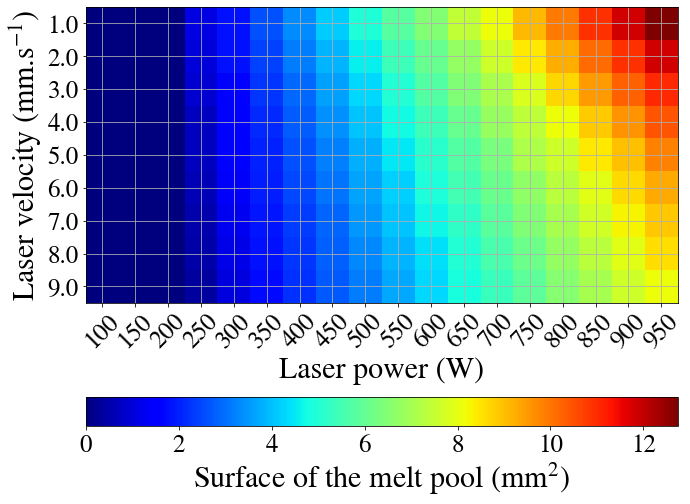

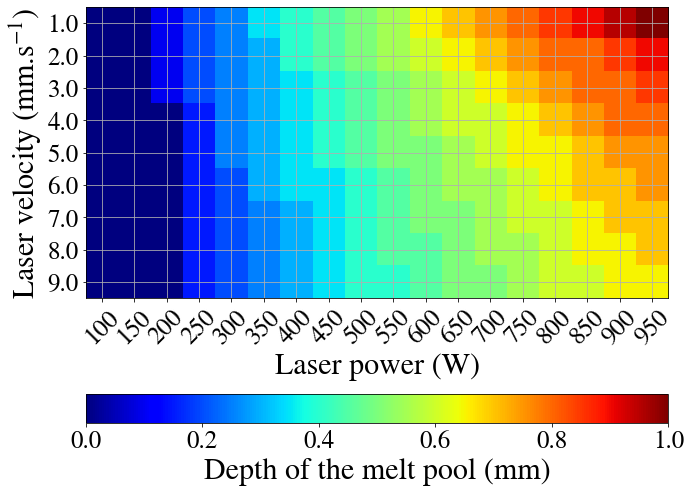

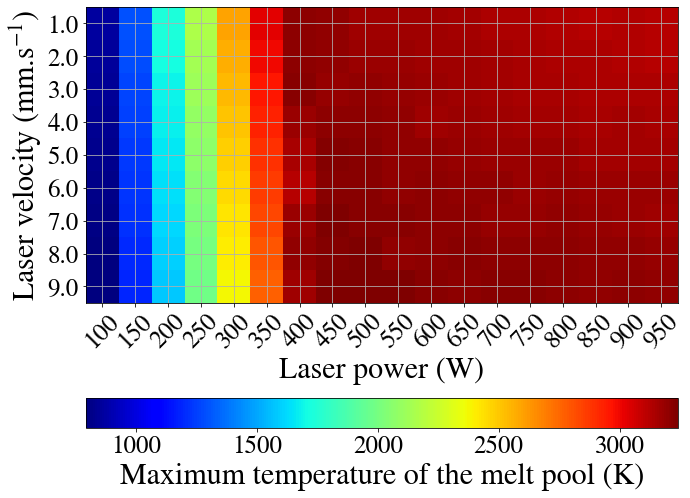

In [19]:
fig, ax = plt.subplots(figsize = (10,8))
im = ax.imshow(surf_all, cmap='jet')
ax.set_xlabel('Laser power (W)')
ax.set_xticks(np.arange(len(P)))
ax.set_xticklabels(pticks, rotation = 45)
ax.set_ylabel(r'Laser velocity (mm.s$^{-1}$)')
ax.set_yticks(np.arange(len(V)))
ax.set_yticklabels(labels = vticks)
cbar = fig.colorbar(im, ax = ax, orientation = 'horizontal',fraction = 0.08, pad = 0.2)
cbar.set_label(r"Surface of the melt pool (mm$^{2}$)", rotation = 0)

fig, ax = plt.subplots(figsize = (10,8))
im = ax.imshow(depth_all, cmap='jet')
ax.set_xlabel('Laser power (W)')
ax.set_xticks(np.arange(len(P)))
ax.set_xticklabels(pticks, rotation = 45)
ax.set_ylabel(r'Laser velocity (mm.s$^{-1}$)')
ax.set_yticks(np.arange(len(V)))
ax.set_yticklabels(labels = vticks)
cbar = fig.colorbar(im, ax = ax, orientation = 'horizontal',fraction = 0.08, pad = 0.2)
cbar.set_label("Depth of the melt pool (mm)", rotation = 0)

fig, ax = plt.subplots(figsize = (10,8))
im = ax.imshow(maxT_all, cmap='jet')
ax.set_xlabel('Laser power (W)')
ax.set_xticks(np.arange(len(P)))
ax.set_xticklabels(pticks, rotation = 45)
ax.set_ylabel(r'Laser velocity (mm.s$^{-1}$)')
ax.set_yticks(np.arange(len(V)))
ax.set_yticklabels(labels = vticks)
cbar = fig.colorbar(im, ax = ax, orientation = 'horizontal',fraction = 0.08, pad = 0.2)
cbar.set_label("Maximum temperature of the melt pool (K)", rotation = 0)